In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

In [2]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [3]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [4]:
def build_vgg16_unet(input_shape,num_classes):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

In [5]:
input_shape = (256, 256, 3)
model = build_vgg16_unet(input_shape,1)
model.summary()


Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

# Training

In [6]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, Accuracy, IoU
from sklearn.model_selection import train_test_split


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
drive_path = '/content/drive/MyDrive/PFA' 

In [9]:
H=256
W=256

def create_dir(path):
    """Create a directory"""
    if not os.path.exists(path):
        os.mkdir(path)

In [10]:
def load_data(path, split=0.2):

    images = sorted(glob(f"{path}/ROI/*.bmp"))
    masks = sorted(glob(f"{path}/GT_ICM/*.bmp"))
    
    print(len(masks), len(images))

    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.2, random_state=42)
    print(len(train_x), len(train_y), len(valid_x), len(valid_y))
   
    return (train_x, train_y), (valid_x, valid_y)

In [11]:
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

In [12]:
def read_mask(path):
    path = path.decode('utf-8')
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    '''
    x[x == 255] = 0
    x[x == 223] = 1 #ZP
    x[x == 127] = 2 #TE
    x[x == 191] = 3 #ICM
    x[ x > 3] = 0
    
    x = x.astype(np.int32)
    '''
    x[x!=0] =255
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    
    return x

In [13]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

In [14]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32,  tf.float32]) #was tf.int32
    #y = tf.one_hot(y, 2, dtype=tf.int32)
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1]) #was 4

    return x, y

In [15]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)

    return dataset

In [16]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [17]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

"""Directory for storing files"""
create_dir("/content/drive/MyDrive/PFA/files_vgg16")

"""Hyperparameters"""
batch_size = 10
learning_rate = 1e-4
num_epochs = 70
model_path = os.path.join("/content/drive/MyDrive/PFA/files_vgg16", "model_icm.h5")
csv_path = os.path.join("/content/drive/MyDrive/PFA/files_vgg16", "data_icm.csv")

"""Dataset"""
dataset_path = os.path.join("/content/drive/MyDrive/PFA/new_data")
train_path = os.path.join(dataset_path, "train")

(train_x, train_y), (valid_x, valid_y) = load_data(train_path)


print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)

test_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

"""Model"""

model = build_vgg16_unet((256, 256, 3),1)

metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(learning_rate), metrics=metrics)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [
  ModelCheckpoint(model_path, verbose=1, save_best_only=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
  CSVLogger(csv_path),
  TensorBoard(),
  EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

history = model.fit(
        train_dataset,
        steps_per_epoch=train_steps,
        epochs=num_epochs,
        validation_data=test_dataset,
        validation_steps=valid_steps,
        callbacks=callbacks
    )
  

945 945
756 756 189 189
Train: 756 - 756
Valid: 189 - 189
Epoch 1/70
75/75 [==============================] - ETA: 0s - loss: 0.6377 - dice_coef: 0.3623 - iou: 0.2270 - accuracy: 0.8002 - recall: 0.9345 - precision: 0.2778
Epoch 1: val_loss improved from inf to 0.80452, saving model to /content/drive/MyDrive/PFA/files_vgg16/model_icm.h5
75/75 [==============================] - 70s 735ms/step - loss: 0.6377 - dice_coef: 0.3623 - iou: 0.2270 - accuracy: 0.8002 - recall: 0.9345 - precision: 0.2778 - val_loss: 0.8045 - val_dice_coef: 0.1955 - val_iou: 0.1085 - val_accuracy: 0.4416 - val_recall: 0.7689 - val_precision: 0.1010 - lr: 1.0000e-04
Epoch 2/70
75/75 [==============================] - ETA: 0s - loss: 0.4186 - dice_coef: 0.5810 - iou: 0.4102 - accuracy: 0.9686 - recall: 0.9301 - precision: 0.7438
Epoch 2: val_loss improved from 0.80452 to 0.61594, saving model to /content/drive/MyDrive/PFA/files_vgg16/model_icm.h5
75/75 [==============================] - 58s 682ms/step - loss: 0.418

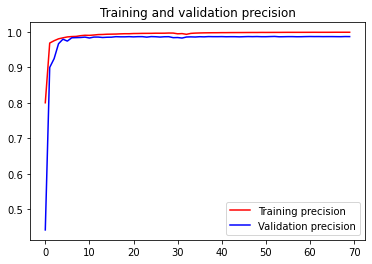

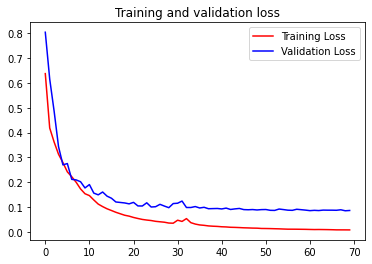

In [18]:
# Plot the chart for accuracy and loss on both training and validation
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training precision')
plt.plot(epochs, val_acc, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
def load_data(path):

    images = sorted(glob(f"{path}/ROI/*.bmp"))
    masks = sorted(glob(f"{path}/GT_ICM/*.bmp"))
    
    print(len(images), len(masks))
   
    return (images, masks)

In [20]:
test_path = os.path.join(dataset_path, "test")
(test_x, test_y) = load_data(test_path)

48 48


In [23]:
from tqdm import tqdm
num_classes = 1

In [24]:
res_path = os.path.join(dataset_path, "results_vgg16_ICM")
create_dir(res_path)
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        name = x.split("/")[-1]

        ## Read image
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = x / 255.0
        x = x.astype(np.float32)
        
        ## Read mask
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y[y == 255] = 0
        y[y == 223] = 1 #ZP
        y[y == 127] = 2 #TE
        y[y == 191] = 3 #ICM
        y[ y > 3] = 0
        y = np.expand_dims(y, axis=-1) ## (256, 256, 1)
        y = y * (255/num_classes)
        y = y.astype(np.int32)
        y = np.concatenate([y, y, y], axis=2)

        ## Prediction
        
        p = model.predict(np.expand_dims(x, axis=0))[0]
        
        p = p > 0.5
        p = p.astype(np.int32)
        p = p *255
        '''
        mask = model.predict(x)[0]
        mask = mask > 0.5
        mask = mask.astype(np.int32)

        x = x * 255.0
        x = x.astype(np.int32)
        
        h, w, _ = x.shape
        line = np.ones((h, 10, 3)) * 255

        

        final_image = np.concatenate([x, line, y, line, p], axis=1)
        '''
        status = cv2.imwrite(f"{res_path}/{name}", p)

100%|██████████| 48/48 [00:08<00:00,  5.90it/s]
